In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from astropy.io import fits
from scipy import ndimage
import datetime

In [5]:
def project_maps(name = None, RA = None, DEC = None, allsky_map = None, map_size = 10, 
pixel_size = 1.5, smooth = None):
    '''Creates gnomic projections around given sky coordinates from a healpix-compatible all-sky map. 
    Parameters
    ----------
    name: string or string array, optional
        name of objects, will be used as file name if files are written. Default:None
    RA: float or float array array, optional
        Right acention of objects, fk5 coordinates are required. Default:None
    DEC: float or float array, optional
        Declination of objects, fk5 coordinates are required. Default:None
    allsky_map: float_array, optional
        all-sky map in healpix ring-ordered format. To be used as source map. Default:None
    map_size: float, optional
        size of the desired projected map in degree, map will be square. Default: 10
    pixel_size: float, optional
        pixel size of the desired projected map in arcmin. Default: 1.5
    smooth: float, optional
        fwhm of gaussian kernel for smoothing of output maps. Default: None


    Returns
    -------
    output: array
        single image or data cube containing the projected maps. 
        If out_path is set, one or several files will be written
    '''

    npix = np.int(round(map_size*60 / pixel_size))

    projected_map = hp.gnomview(allsky_map, coord=('G','C'), rot=(RA,DEC), return_projected_map=True, xsize=npix, reso=pixel_size, no_plot=True)
    if smooth is not None:
        projected_map = ndimage.gaussian_filter(projected_map, sigma=smooth*fwhm2sigma/pixel_size, order=0, mode = "reflect", truncate = 10)

    return(projected_map)


def create_header(name, RA, DEC, npix, pixel_size):
    '''Creates a fits-compatible header. 
    Parameters
    ----------
    name: string
        name of the object
    RA: float
        Right acention of objects, fk5 coordinates are required
    DEC: float
        Declination of objects, fk5 coordinates are required
    pixel_size: float
        pixel size in arcmin

    Returns
    -------
    header: fits header
    '''

    today = str(datetime.date.today())
    c0 = fits.Card('SIMPLE', True, ' conforms to FITS standard')
    c1 = fits.Card('BITPIX', -32, ' array data type')
    c2 = fits.Card('NAXIS', 2, ' ')
    c3 = fits.Card('NAXIS1', npix, ' ')
    c4 = fits.Card('NAXIS2', npix, ' ')
    c5 = fits.Card('DATE', today, ' Creation date (CCYY-MM-DD) of FITS header')
    c6 = fits.Card('BUNIT', 'Compton-y', ' X-axis ')
    c7 = fits.Card('BAD_DATA', -1.6375E30, ' value for missing data')
    #
    c8 = fits.Card('RADECSYS', 'FK5', ' Celestial coordinate system')
    c9 = fits.Card('EQUINOX', 2000, ' Equinox of Ref. Coord.')
    c10 = fits.Card('PC1_1', 1.0, ' Degrees / Pixel')
    c11 = fits.Card('PC2_1', 0.0, ' Degrees / Pixel')
    c12 = fits.Card('PC1_2', 0.0, ' Degrees / Pixel')
    c13 = fits.Card('PC2_2', 1.0, ' Degrees / Pixel')
    #
    c14 = fits.Card('CTYPE1', 'RA---TAN', ' X-axis ')
    c15 = fits.Card('CRVAL1', RA, ' Origin coordinate')
    c16 = fits.Card('CRPIX1', (npix+1)/2., ' Origin pixel index (1 based)')
    c17 = fits.Card('CDELT1', -pixel_size/60.0, ' Degrees/pixel')
    #
    c18 = fits.Card('CTYPE2', 'DEC--TAN', ' Y-axis ')
    c19 = fits.Card('CRVAL2', DEC, ' Origin coordinate')
    c20 = fits.Card('CRPIX2', (npix+1)/2., ' Origin pixel index (1 based)')
    c21 = fits.Card('CDELT2', pixel_size/60.0, ' Degrees/pixel')
    #
    c22 = fits.Card('LONPOLE', 180.0 , ' Native longitude of Celestial pole')
    c23 = fits.Card('LATPOLE', 0.0, ' Celestial latitude of native pole')
    c24 = fits.Card('EXTEND', True, ' ')
    #
    header = fits.Header([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24])

    return(header)


def writefits(file_name, data, header=None):
    '''Writes a 2D array (usually an image) to a fits file.

    Parameters
    ----------
    file_name: string
        Name of the fits file
    data: float array
        2D array to be written
    header: fits header
        Optional fits header. A minimal header is created
        automatically if none is provided. Default: None    
    Returns
    -------
    None
    '''

    hdu = fits.PrimaryHDU()
    hdu.data = np.array(data, dtype=np.float32)
    if header is not None:	
        hdu.header = header
    hdu.writeto(file_name, overwrite=True)

    return(None)

# The Code starts here

In [6]:
#read Planck allsky map
allsky_y_map = hp.read_map("milca_ymaps.fits", dtype = np.float32)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
RA = 194.9531 
Dec = 27.9807
name = "Coma Cluster"

pixel_size = 1.5 #arcmin/pixel
map_size = 10 #degrees
npix = map_size*60/pixel_size

y_map = project_maps(name = name, RA = RA, DEC = Dec, allsky_map = allsky_y_map, pixel_size = pixel_size, map_size = map_size)
header = create_header(name, RA, Dec, npix, pixel_size)

writefits('Coma.fits', y_map, header)

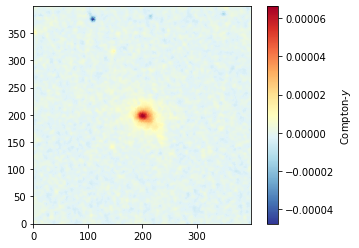

In [11]:
plt.imshow(y_map, origin = "lower", cmap = "RdYlBu_r")
plt.colorbar(label = "Compton-$y$")